__Purpose:__ Introduce Federated Learning, specifically by implementing FedAveraging on our dataset and moving on to more advanced methods.  Start by modifying the Simulations code, worry about (a)synchronicity later.
<br>
1. We are assuming we can test on the second half (updates 10-19ish) since (human/co-adaptive) learning should be complete by then!  For reasons shown in earlier NBs

In [1]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

from experiment_params import *
from cost_funcs import *
from fl_sim_classes import *
import time
import pickle
from sklearn.decomposition import PCA

In [2]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

# For exclusion when plotting later on
bad_nodes = [1,3,13]

# Reminder of Conditions Order

NOTE: 

* **CONDITIONS** = array(['D_1', 'D_2', 'D_5', 'D_6', 'D_3', 'D_4', 'D_7','D_8']
* **LEARNING RATES:** alpha = 0.25 and 0.75; alpha = 0.25 for D1, D2, D5, D6; alpha = 0.75 for D3, D4, D7, D8
* **SMOOTHBATCH:** W_next = alpha*W_old + ((1 - alpha) * W_calc)

* **DECODER INIT:** pos for D1 - D4, neg for D5 - D8

* **PENALTY TERM:** $\lambda_E$ = 1e-6 for all, $\lambda_F$ = 1e-7 for all, $\lambda_D$ = 1e-3 for 1, 3, 5, 7 and 1e-4 for 2, 4, 6, 8 


| DECODER | ALPHA | PENALTY | DEC INIT |
| --- | --- | --- | --- |
| 1 | 0.25 | 1e-3 | + |
| 2 | 0.25 | 1e-4 | + |
| 3 | 0.75 | 1e-3 | + |
| 4 | 0.75 | 1e-4 | + |
| 5 | 0.25 | 1e-3 | - |
| 6 | 0.25 | 1e-4 | - |
| 7 | 0.75 | 1e-3 | - |
| 8 | 0.75 | 1e-4 | - |


# Verify Federated Set Up Runs

In [3]:
with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)
    
with open(path+all_decs_init_filename, 'rb') as fp:
    init_decoders = pickle.load(fp)
cond0_init_decs = [dec[0, :, :] for dec in init_decoders]

In [4]:
D_0 = np.random.rand(2,64)
D_0_7 = np.random.rand(2,7)

# Federated Learning
## 1 Scipy Step, 1000 Iterations
> Note that the thicker, lighter lines are the global model accuracies, whereas the thin lines are the local accuracies.

In [5]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 1000
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))

(Current Local Round, Current Local Update)
(149, 15)
(132, 15)
(161, 16)
(145, 15)
(121, 14)
(139, 15)
(151, 16)
(132, 15)
(156, 16)
(147, 15)
(136, 15)
(154, 16)
(126, 15)
(151, 16)


In [6]:
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))

(Current Local Round, Current Local Update)
(149, 15)
(132, 15)
(161, 16)
(145, 15)
(121, 14)
(139, 15)
(151, 16)
(132, 15)
(156, 16)
(147, 15)
(136, 15)
(154, 16)
(126, 15)
(151, 16)


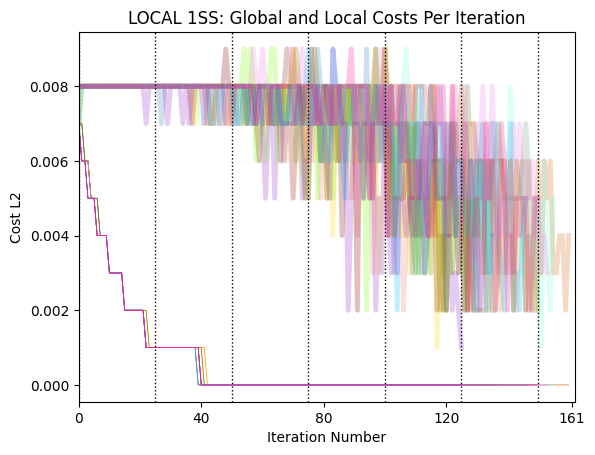

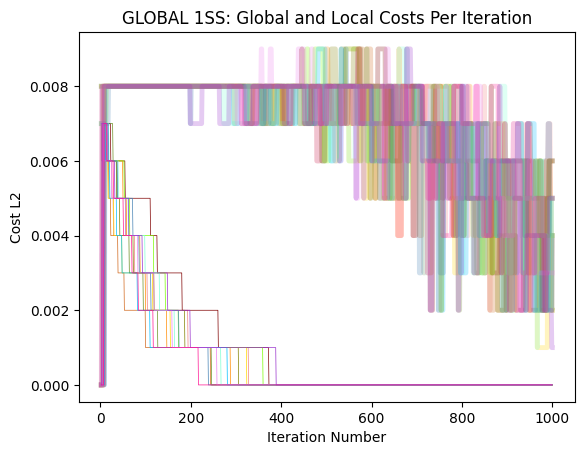

In [7]:
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='LOCAL 1SS: Global and Local Costs Per Iteration')
condensed_external_plotting(global_model_1scipystep, 'global', show_update_change=False, custom_title='GLOBAL 1SS: Global and Local Costs Per Iteration')

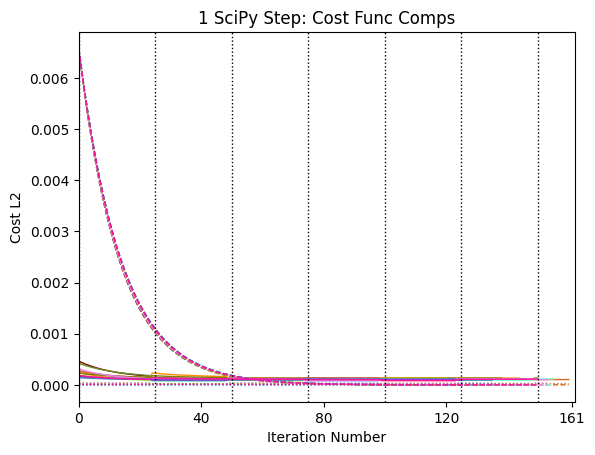

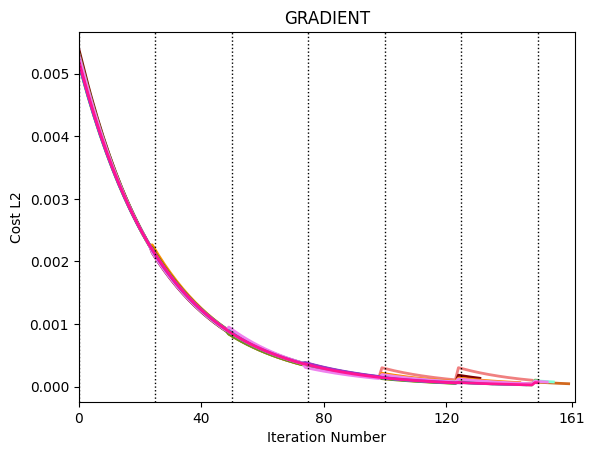

In [8]:
condensed_external_plotting(user_c0_1ScipyStep, 'local', global_error=False, local_error=False, plot_performance=True, plot_Dnorm=True, plot_Fnorm=True, custom_title='1 SciPy Step: Cost Func Comps')
condensed_external_plotting(user_c0_1ScipyStep, 'local', dim_reduc_factor=1, plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

## Testing zvel condition

In [9]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', use_zvel=True, local_round_threshold=50, delay_scaling=0) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 1000
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))

(Current Local Round, Current Local Update)
(116, 12)
(146, 12)
(140, 12)
(132, 12)
(171, 13)
(145, 12)
(125, 12)
(137, 12)
(145, 12)
(167, 13)
(161, 13)
(168, 13)
(134, 12)
(113, 12)


In [10]:
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))

(Current Local Round, Current Local Update)
(116, 12)
(146, 12)
(140, 12)
(132, 12)
(171, 13)
(145, 12)
(125, 12)
(137, 12)
(145, 12)
(167, 13)
(161, 13)
(168, 13)
(134, 12)
(113, 12)


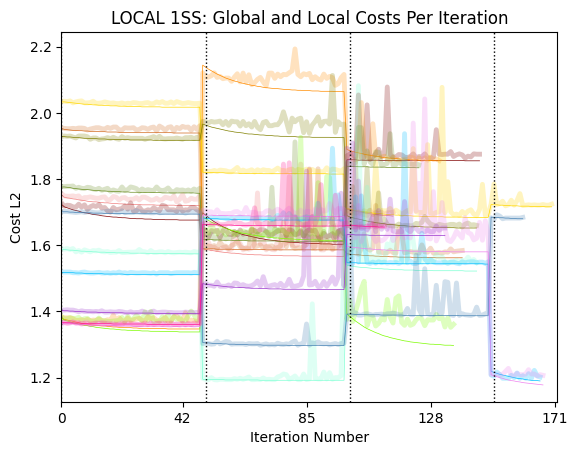

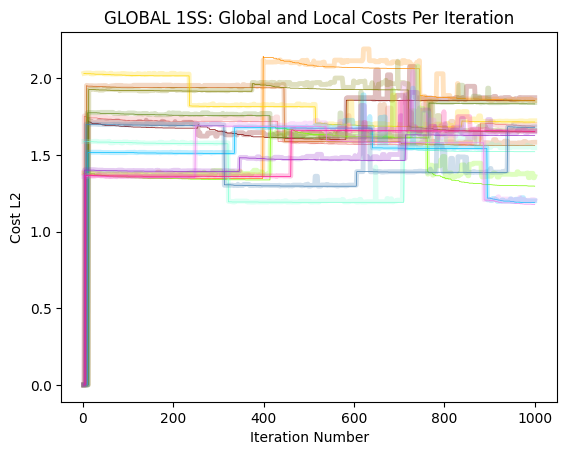

In [11]:
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='LOCAL 1SS: Global and Local Costs Per Iteration')
condensed_external_plotting(global_model_1scipystep, 'global', show_update_change=False, custom_title='GLOBAL 1SS: Global and Local Costs Per Iteration')

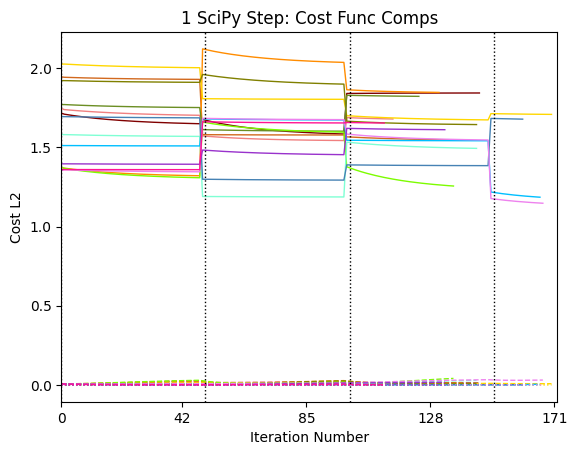

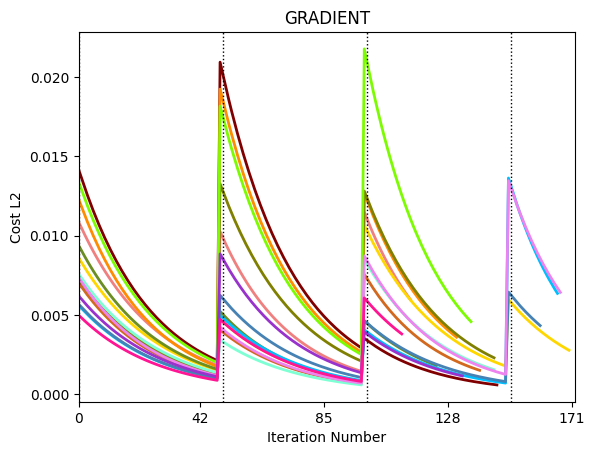

In [12]:
condensed_external_plotting(user_c0_1ScipyStep, 'local', global_error=False, local_error=False, plot_performance=True, plot_Dnorm=True, plot_Fnorm=True, custom_title='1 SciPy Step: Cost Func Comps')
condensed_external_plotting(user_c0_1ScipyStep, 'local', dim_reduc_factor=1, plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

## Making estimates continuous across updates

In [13]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', use_zvel=True, local_round_threshold=50, reuse_prior_est_as_init=True, delay_scaling=0) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 1000
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))

(Current Local Round, Current Local Update)
(131, 12)
(149, 12)
(139, 12)
(148, 12)
(133, 12)
(136, 12)
(146, 12)
(162, 13)
(128, 12)
(142, 12)
(153, 13)
(147, 12)
(148, 12)
(138, 12)


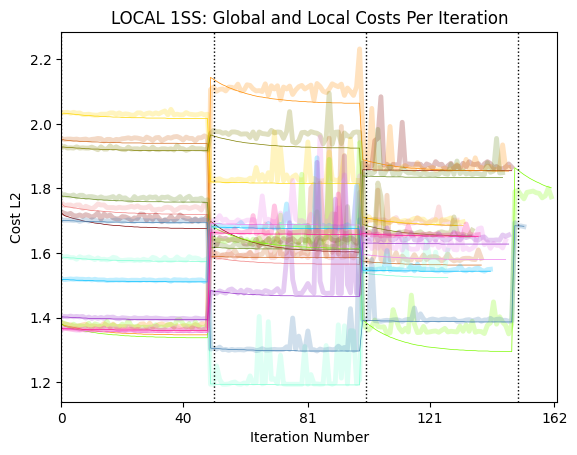

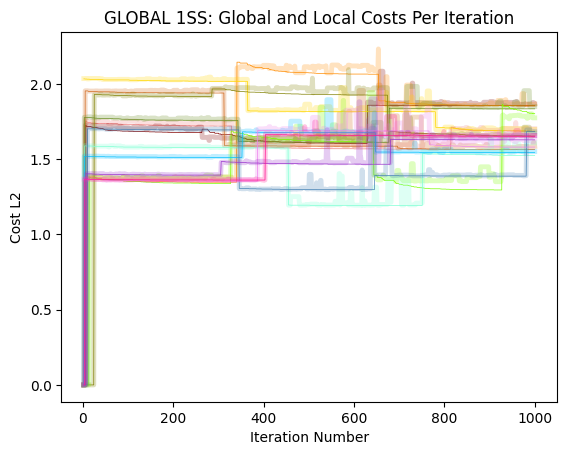

In [15]:
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='LOCAL 1SS: Global and Local Costs Per Iteration')
condensed_external_plotting(global_model_1scipystep, 'global', show_update_change=False, custom_title='GLOBAL 1SS: Global and Local Costs Per Iteration')

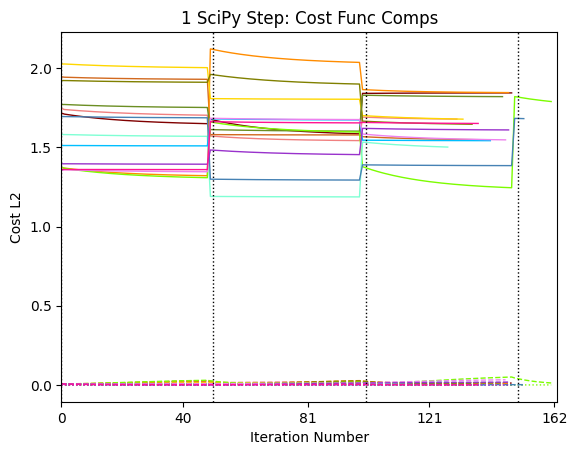

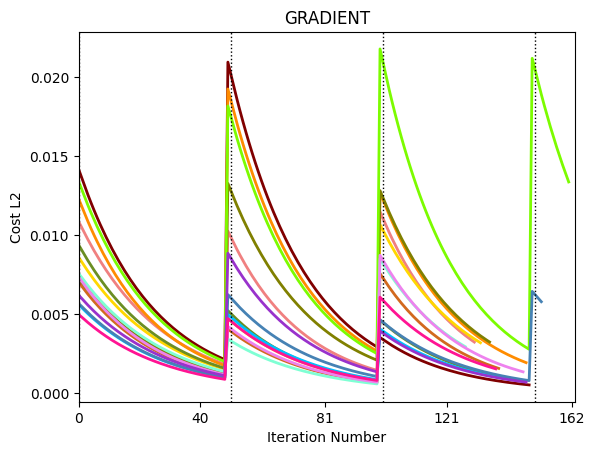

In [16]:
condensed_external_plotting(user_c0_1ScipyStep, 'local', global_error=False, local_error=False, plot_performance=True, plot_Dnorm=True, plot_Fnorm=True, custom_title='1 SciPy Step: Cost Func Comps')
condensed_external_plotting(user_c0_1ScipyStep, 'local', dim_reduc_factor=1, plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')